# NLP for Sentiment Analysis with Twitter Data

## Introduction

The goal of this project is to build a model that can classify the sentiment of a tweet based on its contents. 

The data used is sourced from Twitter from SXSW 2013, and contains tweets about the SXSW tech events and product announcements. Most of the tweets are about Apple and Google products, so I will analyze sentiment for each brand. The raw data can be found in the data folder in this repository.

The data was manually labeled for classification, and contains the tweet text, the product or brand mentioned, and the sentiment as interpreted by the labeler.


## Business Objective

The resulting model will be used to classify tweets from future tech conferences from Google and Apple, and analyze how sentiment for the brands has changed over time. 

## Data Exploration and Cleaning

After running all the relevant imports and the csv file, I can preview the dataset below.There are three columns, where the column describing the brand/product is mostly null. There is only one null in the tweet text column so I will drop that. 

In [110]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#text processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import re
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist

#modeling
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.naive_bayes import ComplementNB

# import warnings
# warnings.filterwarnings('ignore')

In [111]:
raw_data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [112]:
# theres's only one null in the tweet text column so I'm dropping it here
raw_data = raw_data.drop(index=6, axis=0)
raw_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Taking a look at the subjects of the tweets, I can see they are labeled with several subcategories of Google and Apple products. However, most of this column is null values.  

In [113]:
raw_data['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [114]:
raw_data['emotion_in_tweet_is_directed_at'].isna().sum()

5801

And looking at the sentiment, it looks like most of these are labeled as neutral and there are actually very few negative tweets. I assume this is because the tweets are from product announcements at SXSW, so the atmosphere is focused on excitement or news around new product launches. 

In [115]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

I want to take a closer look at the 'I can't tell' category to see if I can group it in with neutral or if I should disregard. 

In [116]:
ct_df = raw_data[raw_data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'I can\'t tell']
ct_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell


Seems like a mixed bag. I'm going to drop these since there are already so many more neutrals, and it would be very manual/subjective to go through and label them myself.

In [117]:
raw_data = raw_data.drop([row for row in ct_df.index])

I also want to preview the neutral tweets... and they look pretty neutral. So I'm going to create a new classifier column to sort these into: -1 for negative and 1 for positive. The neutrals will be the default 0.

In [118]:
ne_df = raw_data[raw_data['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']
ne_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product


In [138]:
#creating a new column for multiclass problem
raw_data['class'] = 0
for row in raw_data.index:
    if raw_data['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'Positive emotion':
        raw_data['class'][row] = 1
    elif raw_data['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'Negative emotion':
        raw_data['class'][row] = -1
        
raw_data.head(10)

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,-1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,-1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,0
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,1
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,1
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,1
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,1


In [139]:
raw_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

The classes are pretty imbalanced. This could become a problem when working through the modeling so I will keep this in mind. 

Another problem is that the data is missing a lot of labels for the product/brand. When I look at the nulls, I can actually see a lot of the product mentions in them so I'm going to see if I can label a few more.

In [122]:
nulls_df = raw_data[raw_data['emotion_in_tweet_is_directed_at'].isna()]

print('There are', len(nulls_df), 'unlabeled tweets out of', len(raw_data),
      'total which equates to', round(len(nulls_df)/len(raw_data)*100,2), "%")

There are 5654 unlabeled tweets out of 8936 total which equates to 63.27 %


In [123]:
nulls_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,0
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product,0
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product,0
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,0
34,Anyone at #SXSW who bought the new iPad want ...,NaN,No emotion toward brand or product,0


Most of the unlabeled tweets are neutral anyway so they really don't have a lot of info. 

In [124]:
nulls_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5297
Positive emotion                       306
Negative emotion                        51
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

However, from the above preview I can clearly see brand/product mentions so I'm going to go through this and search for both Apple and Google related terms.

In [129]:
# if raw_data.index is in apple_indexes:
#     raw_data['emotion_in_tweet_is_directed_at'].fillna('Apple')

These mostly look correct though and I've added 430 new labels to the data. 

In [130]:
# binary indicator
# for value in raw_data['emotion_in_tweet_is_directed_at']:
#     if value == 'iPad' or 'Apple' or'iPad or iPhone App' or 'iPhone' or 'Other Apple product or service':
#         raw_data['apple'] = 1
        
# for value in raw_data['emotion_in_tweet_is_directed_at']:
#     if value == 'Google' or 'Android App' or'Android' or 'Other Google product or service':
#         raw_data['google'] = 1    

SyntaxError: invalid syntax (<ipython-input-130-417b53474525>, line 1)

In [ ]:
grouped_negative = raw_data[raw_data['class'] == -1 ].groupby('emotion_in_tweet_is_directed_at').count()
grouped_negative = grouped_negative.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])

In [ ]:
grouped_negative.plot(kind='bar', stacked=True)

In [ ]:
grouped_positive = raw_data[raw_data['class'] == 1].groupby('emotion_in_tweet_is_directed_at').count()
grouped_positive = grouped_positive.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])
grouped_positive.plot(kind='bar', stacked=True)

In [140]:
grouped_df = raw_data.groupby(['emotion_in_tweet_is_directed_at', 'class']).count()
grouped_df


tweet_text  \
emotion_in_tweet_is_directed_at class               
Android                         -1              8   
                                 0              1   
                                 1             69   
Android App                     -1              8   
                                 0              1   
                                 1             72   
Apple                           -1             95   
                                 0             21   
                                 1            543   
Google                          -1             68   
                                 0             15   
                                 1            346   
Other Apple product or service  -1              2   
                                 0              1   
                                 1             32   
Other Google product or service -1             47   
                                 0              9   
                                 1            236   
iPad                            -1            125   
                                 0             24   
                                 1            793   
iPad or iPhone App              -1             63   
                                 0             10   
                                 1            397   
iPhone                          -1            103   
                                 0              9   
                                 1            184   

                                       is_there_an_emotion_directed_at_a_brand_or_product  
emotion_in_tweet_is_directed_at class                                                      
Android                         -1                                                     8   
                                 0                                                     1   
                                 1                                                    69   
Android App                     -1                                                     8   
                                 0                                                     1   
                                 1                                                    72   
Apple                           -1                                                    95   
                                 0                                                    21   
                                 1                                                   543   
Google                          -1                                                    68   
                                 0                                                    15   
                                 1                                                   346   
Other Apple product or service  -1                                                     2   
                                 0                                                     1   
                                 1                                                    32   
Other Google product or service -1                                                    47   
                                 0                                                     9   
                                 1                                                   236   
iPad                            -1                                                   125   
                                 0                                                    24   
                                 1                                                   793   
iPad or iPhone App              -1                                                    63   
                                 0                                                    10   
                                 1                                                   397   
iPhone                          -1                                                   103   
                 

In [131]:
test = raw_data.groupby(['emotion_in_tweet_is_directed_at', 'class']).count()['is_there_an_emotion_directed_at_a_brand_or_product']

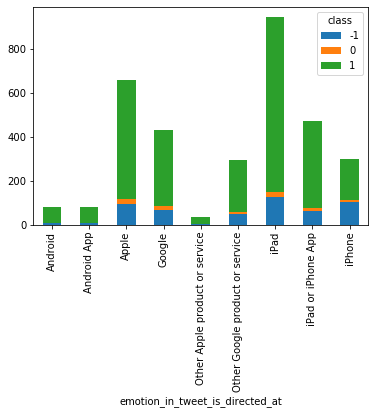

In [132]:
test.unstack().plot(kind='bar', stacked=True)

Text(0.5, 1.0, 'Neutral')

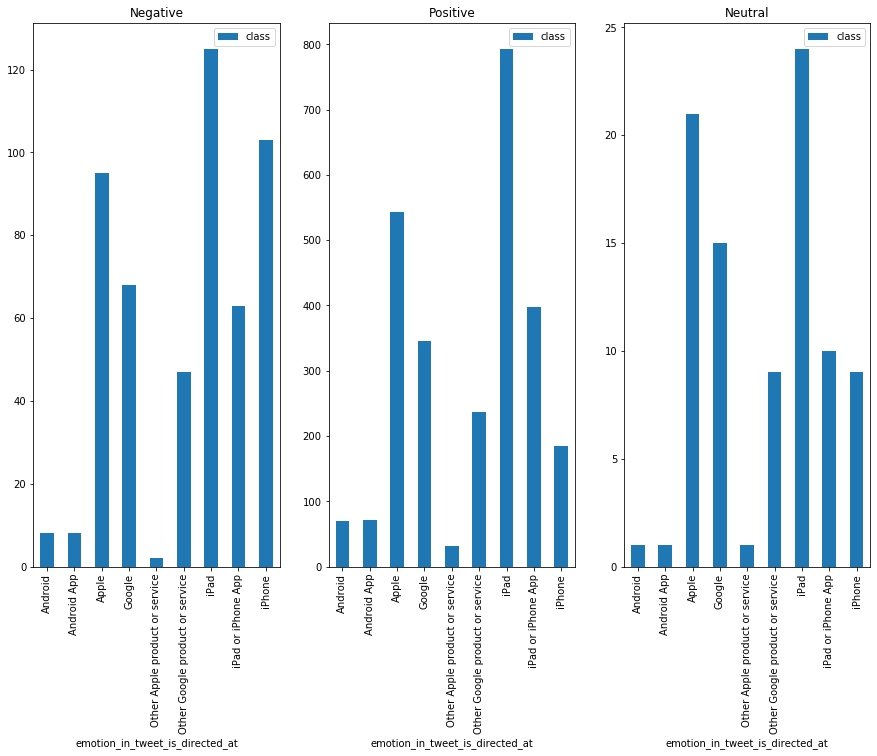

In [104]:
# # plt.figure(figsize=(20, 10))
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,10))


# ax1 = grouped_negative.plot(kind='bar', ax=ax1, stacked=True)
# ax1.set_title('Negative')

# ax2 = grouped_positive.plot(kind='bar', ax=ax2, stacked=True)
# ax2.set_title('Positive')

# ax3 = grouped_neutral.plot(kind='bar', ax=ax3, stacked=True)
# ax3.set_title('Neutral')

# # plt.savefig('Images/sentiment_bars')

In [28]:
raw_data['class'].value_counts(normalize=True)

 0    0.602954
 1    0.333259
-1    0.063787
Name: class, dtype: float64

## Preprocessing

I'm going to start a new column for processed text. The first step I am going to take is to remove handles, since they aren't actual content and shouldn't convey tone. 

I'm using regex to grab these as well as URLs replace them with nothing. The example below shows they have been removed!

In [141]:
raw_data['clean_tweet'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet) for tweet in raw_data['tweet_text']]

In [142]:
print(raw_data.iloc[14][0])
print(raw_data.iloc[14][4])

haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw
haha, awesomely rad iPad app by   #hollergram #sxsw


Now, I can compile a list of stopwords from NLTK so I can remove all the filler words in the text that don't actually contain any information. This will also remove punctuation for when the tweets are tokenized. 

In [143]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``']
stopwords_list += punct_list

Before I move into modeling, I am going to take a look at what my data will contain when tokenized:

In [158]:
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    words_lower = [token.lower() for token in tokens]
    words_stopped = [word for word in words_lower if word not in stopwords_list]
    return words_stopped

processed_data = list(map(process_tweet, raw_data['clean_tweet']))

In [160]:
processed_data[0]

['3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In this set with stop words removed there are 10,560 unique words,and some of the most frequent are general twitter words - 'rt', 'link'. Many however are referring to products and events. The word cloud helps demonstrate the scope of the subjects of these tweets.

In [33]:
total_vocab = set()
for token in processed_data:
    total_vocab.update(token)
    
print(len(total_vocab))

10444


In [34]:
tweet_concat = []
for tweet in processed_data:
    tweet_concat += tweet
    
tweet_freqdist = FreqDist(tweet_concat)
tweet_freqdist.most_common(2000)

[('sxsw', 9352),
 ('link', 4265),
 ('rt', 2926),
 ('google', 2543),
 ('ipad', 2402),
 ('apple', 2267),
 ('quot', 1657),
 ('iphone', 1497),
 ('store', 1455),
 ("'s", 1218),
 ('2', 1104),
 ('new', 1078),
 ('austin', 948),
 ('amp', 834),
 ('app', 811),
 ('launch', 647),
 ('social', 636),
 ('circles', 634),
 ('android', 572),
 ('today', 572),
 ("n't", 467),
 ('network', 458),
 ('ipad2', 455),
 ('pop-up', 411),
 ('via', 405),
 ('line', 393),
 ('free', 387),
 ('get', 383),
 ('called', 354),
 ('party', 345),
 ('mobile', 337),
 ('sxswi', 337),
 ('one', 305),
 ('major', 300),
 ('like', 280),
 ('time', 270),
 ("'re", 262),
 ('temporary', 262),
 ('opening', 256),
 ("'m", 252),
 ('possibly', 236),
 ('downtown', 225),
 ('people', 223),
 ('apps', 222),
 ('great', 221),
 ('see', 218),
 ('maps', 216),
 ('day', 216),
 ('check', 215),
 ('mayer', 214),
 ('going', 213),
 ('open', 209),
 ('popup', 208),
 ('need', 202),
 ('go', 197),
 ('marissa', 189),
 ('got', 182),
 ('know', 181),
 ('w/', 181),
 ('come', 

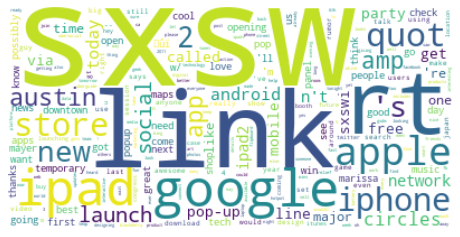

In [35]:
wc = WordCloud(background_color="white", max_words=2000)
wc.generate_from_frequencies(tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.show()

In [36]:
#lemmatization

# import spaCy's language model 
# nlp = spacy.load('en', disable=['parser', 'ner'])

# # function to lemmatize text
# def lemmatization(texts):
#     output = []
#     for i in texts:
#         s = [token.lemma_ for token in nlp(i)]
#         output.append(' '.join(s))
#     return output

## Modeling with Classifiers

Now that I have a thorough understanding of the data, I'm going to test out different classifiers to see how effective they are. I'll start with Multinomial Naive Bayes as my baseline model, as this is commonly used for NLP.

### Baseline Model: Multinomial Naive Bayes with Count Vectorizer

I'll also use a count vectorizer with this baseline model since it's one of the more simple techniques. Count Vectorizer converts text into a vector based on the count of each word occuring in the text. 

I'll pull in my cleaned text that I defined above and fit to train and test variables. 

In [37]:
X = raw_data['clean_tweet']
y = raw_data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [38]:
count_vectorizer = CountVectorizer(stop_words=stopwords_list)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

Now I'll instantiate the classifier and fit it to the vectorized variables. I am defining a function to easily return the score of the classifier as well as a confusion matrix so I can compare performance of different models. 

In [39]:
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train_count, y_train)

MultinomialNB()

In [40]:
def score(clf, X_train, y_train, X_test, y_test):
    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)
    train_score = accuracy_score(y_train, train_preds)
    test_score = accuracy_score(y_test, test_preds)
    print('test accuracy score =', test_score, 
          'train accuracy score =', train_score)
    plot_confusion_matrix(clf, X_test, y_test)

test accuracy score = 0.658012533572068 train accuracy score = 0.8285586392121754


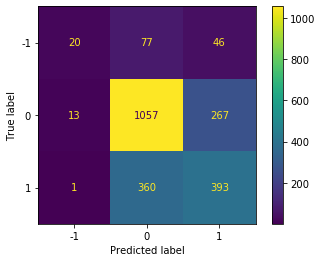

In [41]:
score(nb_classifier, X_train_count, y_train, X_test_count, y_test)

My first model is quite overfit, and it may be having trouble learning because the classes are so imbalanced. The next thing I'm going to try is changing to a TF-IDF vectorizer, which penalizes words that show up more frequently. This could help the model value words like sxsw, google, and apple less, and instead actually look for words that indicate sentiment.

### MNB with TF-IDF

As a starting point, I'm setting the TF-IDF vectorizer to ignore terms that appear in more than 90% of the tweets. Now I can see that more unique words, like 'giveaway' are rising to the top.

In [42]:
tfidf = TfidfVectorizer(stop_words=stopwords_list, 
                        max_df = .90, 
                        use_idf=True)

tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [43]:
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

In [44]:
# Grabbing that row once it's been vectorized
test_doc = tfidf_test_df.iloc[5]

print(test_doc.loc[test_doc > 0].sort_values(ascending=False)) # Showing values > 0

recs         0.629717
sloanxsw     0.314859
fr           0.300856
discotalk    0.300856
def          0.276918
end          0.232048
guys         0.220204
hotpot       0.208904
panel        0.177746
great        0.163743
social       0.125228
amp          0.119591
google       0.079672
rt           0.076771
Name: 5, dtype: float64


In [45]:
nb_tfidf = MultinomialNB()

nb_tfidf.fit(tfidf_train, y_train)

MultinomialNB()

test accuracy score = 0.6459265890778872 train accuracy score = 0.7660399880632647


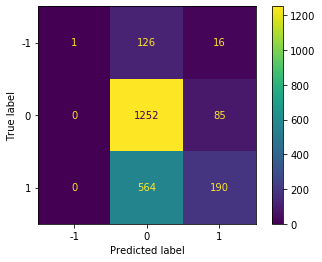

In [46]:
score(nb_tfidf, tfidf_train, y_train, tfidf_test, y_test)

This model is less overfit, and it seems to be learning some patterns, but it's still not good. It only correctly predicted one negative. The test score actually went down as well, so I'm going to try another type of classifier.

### Complement Naive Bayes

Complement Naive Bayes is similar to MNB, but is adapted to suit imbalanced data sets as it uses the complement of each class to compute the model’s weights. According to SciKit learn documentation, CNB regularly outperforms MNB on text classification tasks.


In [47]:
cnb = ComplementNB()
cnb.fit(tfidf_train, y_train)

ComplementNB()

test accuracy score = 0.6432408236347359 train accuracy score = 0.8222918531781558


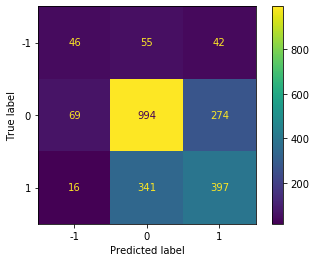

In [48]:
score(cnb, tfidf_train, y_train, tfidf_test, y_test)

CNB barely increased the test score, but made the model even more overfit! I'm going to try something different.

### Support Vector Machines

SVMs are said to help reduce overfitting, and SVC has a regularization parameter C which can be tuned. There are also different kernel types that can be applied. 

After exploring different values for C, I am able to reduce overfitting, which is a strength of using this model type. 

test accuracy score = 0.6754700089525515 train accuracy score = 0.8439271859146523


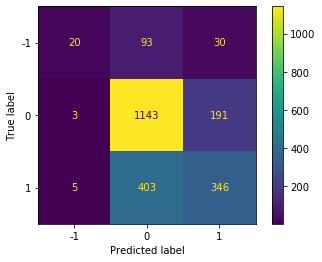

In [49]:
#starting with 1
svc_clf = SVC(kernel= 'linear', C=1)
svc_clf.fit(tfidf_train, y_train)
score(svc_clf, tfidf_train, y_train, tfidf_test, y_test)

test accuracy score = 0.6678603401969562 train accuracy score = 0.7730528200537153


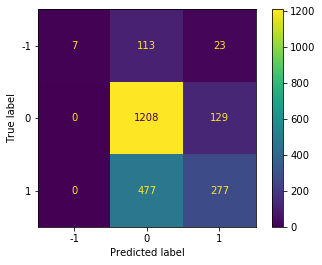

In [50]:
#reducing to 0.5 = stronger regulation
svc_clf = SVC(kernel= 'linear', C=0.5)
svc_clf.fit(tfidf_train, y_train)
score(svc_clf, tfidf_train, y_train, tfidf_test, y_test)

test accuracy score = 0.640107430617726 train accuracy score = 0.6674127126230975


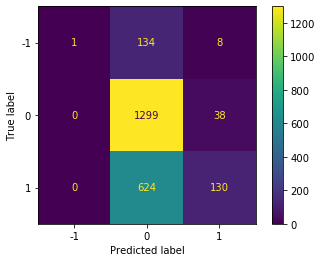

In [51]:
#still overfit! reducing a bit more
svc_clf = SVC(kernel= 'linear', C=0.2)
svc_clf.fit(tfidf_train, y_train)
score(svc_clf, tfidf_train, y_train, tfidf_test, y_test)

The tradeoff to reducing overfitting in this model is that the accuracy score was sacrificed. It's predicting almost everything as a zero. 

## Modeling with Deep Learning

Since these classifiers aren't seeing great results, I'm going to take this a step further with pre-trained word embeddings and neural networks.

### GloVe

Global Vectors for Word Representation is a pre-trained model by the Stanford NLP Group, trained on massive data sets to obtain vector representations for words. To use it I will need to leverage keras, and import the glove text file.

In [52]:
#imports for keras/tensorflow to use gloVe with neural nets
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [53]:
glove = {}
with open('data/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

GloVe has vectorized the words in my data set:

In [54]:
glove['sxsw']

array([-0.54213  , -0.40598  , -0.57972  ,  0.68902  , -1.2828   ,
       -1.4274   , -0.3113   , -0.37996  ,  0.85759  ,  0.74349  ,
       -0.27944  , -1.2856   ,  0.30916  ,  0.10983  ,  0.76612  ,
        0.052707 , -0.045862 ,  0.97209  , -0.388    ,  0.0061045,
        0.36166  ,  0.063978 ,  0.60576  ,  1.1596   , -0.22204  ,
        0.55524  , -1.1646   , -0.11687  , -1.2104   , -0.90578  ,
        0.36391  ,  0.20946  , -0.19362  , -0.99614  , -0.18209  ,
       -0.13782  ,  0.2144   , -0.038234 , -0.29907  , -0.39556  ,
       -0.61547  ,  0.1485   , -1.0864   , -0.42129  , -0.42307  ,
        0.51809  ,  1.0751   , -0.30472  , -1.4201   ,  1.007    ],
      dtype=float32)

Now I'm going to define a class to create mean word embeddings:

In [55]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # adding a 'fit' method so I can use in a pipeline
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

Here I'm going to use Keras' preprocessing tools to tokenize each example, convert them to sequences, and then pad the sequences so they're all the same length.

In [56]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(X_train))
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_train_token = sequence.pad_sequences(X_train_tokenized, maxlen=100)
X_test_token = sequence.pad_sequences(X_test_tokenized, maxlen=100)

In [57]:
X_train_token.shape

(6702, 100)

I'll also use keras to encode my y for 3 classes.

In [58]:
# num_classes = 3

# # convert class vectors to class matrices
# y_train_cat = keras.utils.to_categorical(y_train, num_classes)
# y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [59]:
y_train_enc = pd.get_dummies(y_train).values
y_test_enc = pd.get_dummies(y_test).values
y_train_enc.shape

(6702, 3)

Both variables appear to be the right dimesions. Time to try a neural net. I'm going to build a sequential model, starting with an embedding layer of 10000 words, which is the number of words in the tokenizer. I'm setting the embedding size as 100 which is the max length parameter I used above.

I am then adding two layers, an LSTM and dense layers. To keep it simple, I'm going to run this for 3 epochs. 

My model will evaluate on accuracy, and use the selected loss function and optimizer. 

In [60]:
np.random.seed(10)
model1 = Sequential()

In [61]:
embedding_size = 100
model1.add(Embedding(10000, embedding_size))
model1.add(LSTM(25, return_sequences=True))
model1.add(GlobalMaxPool1D())
model1.add(Dense(50, activation='relu'))
model1.add(Dense(3, activation='relu'))

In [62]:
model1.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 25)          12600     
_________________________________________________________________
global_max_pooling1d (Global (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 1,014,053
Trainable params: 1,014,053
Non-trainable params: 0
_________________________________________________________________


In [63]:
model_val = model1.fit(X_train_token, y_train_enc, epochs=3, batch_size=32, validation_split=0.1)

Epoch 1/3
189/189 [==============================] - 23s 101ms/step - loss: 1.2406 - accuracy: 0.5847 - val_loss: 0.8505 - val_accuracy: 0.6453
Epoch 2/3
189/189 [==============================] - 18s 93ms/step - loss: 0.7286 - accuracy: 0.6784 - val_loss: 0.8545 - val_accuracy: 0.6870
Epoch 3/3
189/189 [==============================] - 18s 97ms/step - loss: nan - accuracy: 0.5901 - val_loss: nan - val_accuracy: 0.0671


Within the three iterations, this model didn't learn much.

In [64]:
def evaluate_nn(model, X_train, X_test, y_train, y_test):
    results_train = model.evaluate(X_train_token, y_train_enc)
    results_test = model.evaluate(X_test_token, y_test_enc)

    print('----------')
    print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
    print('----------')
    print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

In [65]:
evaluate_nn(model1, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 18ms/step - loss: nan - accuracy: 0.0640
----------
Training Loss: nan 
Training Accuracy: 0.0637
----------
Test Loss: nan 
Test Accuracy: 0.064


In an attempt to add regularization parameters, I'm going to add dropout layers to hopefully make the model less sensitive to variance. I'll also add more epochs to allow it to learn.

In [66]:
np.random.seed(10)
model2 = Sequential()

model2.add(Embedding(10000, embedding_size))
model2.add(LSTM(25, return_sequences=True))
model2.add(GlobalMaxPool1D())
model2.add(Dropout(0.5))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax'))

In [67]:
model2.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [68]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 25)          12600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [69]:
model2_val = model2.fit(X_train_token, y_train_enc, epochs=6, batch_size=32)

Epoch 1/6
210/210 [==============================] - 27s 93ms/step - loss: 0.9363 - accuracy: 0.5889
Epoch 2/6
210/210 [==============================] - 20s 95ms/step - loss: 0.8215 - accuracy: 0.6302
Epoch 3/6
210/210 [==============================] - 21s 98ms/step - loss: 0.6633 - accuracy: 0.7296
Epoch 4/6
210/210 [==============================] - 19s 93ms/step - loss: 0.5315 - accuracy: 0.7906
Epoch 5/6
210/210 [==============================] - 18s 88ms/step - loss: 0.4274 - accuracy: 0.8355
Epoch 6/6
210/210 [==============================] - 19s 90ms/step - loss: 0.3425 - accuracy: 0.86831s - loss: 0.3410 - accuracy: 0. - ETA: 


In [70]:
evaluate_nn(model2, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 18ms/step - loss: 1.0939 - accuracy: 0.6652
----------
Training Loss: 0.227 
Training Accuracy: 0.916
----------
Test Loss: 1.09 
Test Accuracy: 0.665


The accuracy score improved pretty quickly, but it appears that the neural net is still really struggling with the test set. 

In [74]:
model2_val.history

{'loss': [0.8928179144859314,
  0.7927796840667725,
  0.657473087310791,
  0.5350093245506287,
  0.43277043104171753,
  0.3557363450527191],
 'accuracy': [0.5920620560646057,
  0.6421963572502136,
  0.7354521155357361,
  0.7858847975730896,
  0.8357206583023071,
  0.863622784614563]}

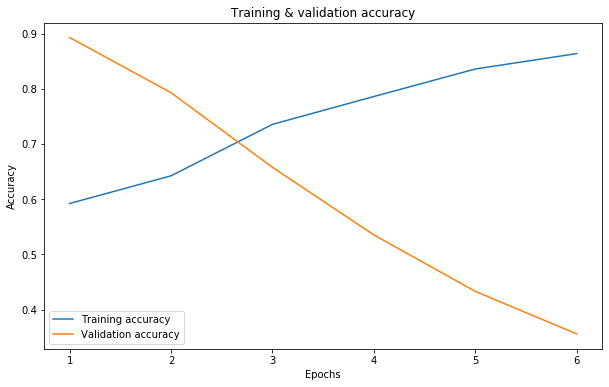

In [76]:
# Access the history attribute and store the dictionary
baseline_model_val_dict = model2_val.history

fig, ax = plt.subplots(figsize=(10, 6))

acc_values = baseline_model_val_dict['accuracy']
loss_values = baseline_model_val_dict['loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, acc_values, label='Training accuracy')
ax.plot(epochs, loss_values, label='Validation accuracy')

ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

There are still many options I can tap into to improve performance. As a next step, I'm going to apply, L2 regularization and run many more epochs. I'll also add early stopping so I don't have an unnecessary amount of runtime. 

In [77]:
early_stopping = [EarlyStopping(monitor='accuracy', patience=10)]

In [78]:
np.random.seed(10)
l2_model = Sequential()

l2_model.add(Embedding(10000, embedding_size))
l2_model.add(LSTM(25, return_sequences=True))
l2_model.add(GlobalMaxPool1D())
l2_model.add(Dropout(0.5))
l2_model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
l2_model.add(Dropout(0.5))
l2_model.add(Dense(3, activation='softmax'))

In [79]:
l2_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [80]:
l2_model_val = l2_model.fit(X_train_token, y_train_enc, 
                            epochs=150, 
                            batch_size=256, 
                            callbacks=early_stopping)



Epoch 1/150
27/27 [==============================] - 11s 204ms/step - loss: 1.2018 - accuracy: 0.5198
Epoch 2/150
27/27 [==============================] - 6s 226ms/step - loss: 1.0196 - accuracy: 0.5853
Epoch 3/150
27/27 [==============================] - 5s 197ms/step - loss: 0.9833 - accuracy: 0.5869
Epoch 4/150
27/27 [==============================] - 6s 204ms/step - loss: 0.9474 - accuracy: 0.5966
Epoch 5/150
27/27 [==============================] - 6s 220ms/step - loss: 0.8843 - accuracy: 0.6038
Epoch 6/150
27/27 [==============================] - 6s 220ms/step - loss: 0.7928 - accuracy: 0.6440
Epoch 7/150
27/27 [==============================] - 6s 215ms/step - loss: 0.7125 - accuracy: 0.7284
Epoch 8/150
27/27 [==============================] - 6s 218ms/step - loss: 0.6491 - accuracy: 0.7799
Epoch 9/150
27/27 [==============================] - 7s 243ms/step - loss: 0.5830 - accuracy: 0.7969
Epoch 10/150
27/27 [==============================] - 6s 218ms/step - loss: 0.5404 - accur

In [81]:
evaluate_nn(l2_model, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 20ms/step - loss: 2.0828 - accuracy: 0.6347 0s - loss: 2.0786 - accuracy: 0.
----------
Training Loss: 0.104 
Training Accuracy: 0.957
----------
Test Loss: 2.08 
Test Accuracy: 0.635


Using L1 regularization

In [82]:
np.random.seed(10)
l1_model = Sequential()

l1_model.add(Embedding(10000, embedding_size))
l1_model.add(LSTM(25, return_sequences=True))
l1_model.add(GlobalMaxPool1D())
l1_model.add(Dropout(0.5))
l1_model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
l1_model.add(Dropout(0.5))
l1_model.add(Dense(3, activation='softmax'))

In [83]:
l1_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [86]:
l1_model_val = l1_model.fit(X_train_token, y_train_enc, 
                            epochs=150, 
                            batch_size=256, 
                            callbacks=early_stopping)

Epoch 1/150
27/27 [==============================] - 13s 209ms/step - loss: 1.8827 - accuracy: 0.5219
Epoch 2/150
27/27 [==============================] - 6s 221ms/step - loss: 1.6128 - accuracy: 0.5900
Epoch 3/150
27/27 [==============================] - 6s 211ms/step - loss: 1.4598 - accuracy: 0.5867
Epoch 4/150
27/27 [==============================] - 6s 207ms/step - loss: 1.3271 - accuracy: 0.5946
Epoch 5/150
27/27 [==============================] - 6s 223ms/step - loss: 1.2024 - accuracy: 0.6016
Epoch 6/150
27/27 [==============================] - 6s 223ms/step - loss: 1.0773 - accuracy: 0.6073
Epoch 7/150
27/27 [==============================] - 6s 228ms/step - loss: 0.9650 - accuracy: 0.6289
Epoch 8/150
27/27 [==============================] - 6s 225ms/step - loss: 0.8489 - accuracy: 0.6967
Epoch 9/150
27/27 [==============================] - 6s 213ms/step - loss: 0.7555 - accuracy: 0.7563
Epoch 10/150
27/27 [==============================] - 6s 221ms/step - loss: 0.6841 - accur

In [87]:
evaluate_nn(l1_model, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 21ms/step - loss: 1.2865 - accuracy: 0.6397 0s - l
----------
Training Loss: 0.315 
Training Accuracy: 0.883
----------
Test Loss: 1.29 
Test Accuracy: 0.64


### Word2Vec

In [88]:
data = raw_data['clean_tweet'].map(word_tokenize)

In [89]:
data[:5]

0    [., I, have, a, 3G, iPhone, ., After, 3, hrs, ...
1    [Know, about, ?, Awesome, iPad/iPhone, app, th...
2    [Can, not, wait, for, #, iPad, 2, also, ., The...
3    [I, hope, this, year, 's, festival, is, n't, a...
4    [great, stuff, on, Fri, #, SXSW, :, Marissa, M...
Name: clean_tweet, dtype: object

In [90]:
processed_data[:5]

[['3g',
  'iphone',
  '3',
  'hrs',
  'tweeting',
  'rise_austin',
  'dead',
  'need',
  'upgrade',
  'plugin',
  'stations',
  'sxsw'],
 ['know',
  'awesome',
  'ipad/iphone',
  'app',
  "'ll",
  'likely',
  'appreciate',
  'design',
  'also',
  "'re",
  'giving',
  'free',
  'ts',
  'sxsw'],
 ['wait', 'ipad', '2', 'also', 'sale', 'sxsw'],
 ['hope',
  'year',
  "'s",
  'festival',
  "n't",
  'crashy',
  'year',
  "'s",
  'iphone',
  'app',
  'sxsw'],
 ['great',
  'stuff',
  'fri',
  'sxsw',
  'marissa',
  'mayer',
  'google',
  'tim',
  "o'reilly",
  'tech',
  'books/conferences',
  'amp',
  'matt',
  'mullenweg',
  'wordpress']]

In [91]:
model = Word2Vec(data, window=5, min_count=1, workers=4)

In [92]:
model.train(data, total_examples=model.corpus_count, epochs=10)

(1353298, 2039070)

In [93]:
wv = model.wv

In [94]:
wv['apple']

array([ 1.3222705 , -1.1893436 ,  1.0431695 , -1.7987713 ,  0.3486156 ,
       -0.2736568 ,  1.3425689 ,  1.1438134 ,  0.68972033, -2.8311844 ,
        1.2824974 , -0.46911642, -0.11890488,  0.09720216, -1.8821588 ,
       -2.4182565 , -0.54758376, -0.3047075 , -0.64375263, -2.0450864 ,
        2.7368877 ,  1.8317478 , -0.09025463, -0.91542494,  0.67666686,
       -0.15279432,  2.5478323 ,  1.4991343 , -1.21942   , -0.8423593 ,
        1.1819087 , -2.8225126 ,  1.2082701 , -0.6424438 , -0.5873484 ,
        0.23099159,  0.40682277,  1.7165742 ,  0.14291134,  0.21857023,
        0.40276593, -0.09087344, -1.1150581 ,  1.9286021 , -0.5663074 ,
       -1.5150869 ,  0.8559327 , -1.5692765 ,  0.4391494 , -0.44435918,
        2.6196306 , -0.46535635, -1.9042122 , -1.4751605 , -0.3438159 ,
        1.5157459 ,  2.1869001 ,  1.0204203 , -1.7264392 , -1.4748904 ,
       -1.4493864 ,  2.3608956 , -1.6174033 , -0.572155  ,  0.00986057,
        1.7089813 ,  0.84856004,  0.81516546, -0.10359367, -1.41

In [95]:
wv.most_similar('apple')


[('popup', 0.765487790107727),
 ('insane..', 0.7632513642311096),
 ('pop-up', 0.7613525986671448),
 ('pop', 0.7534029483795166),
 ('Apple', 0.748151421546936),
 ('emerging', 0.7445507645606995),
 ('wrapping', 0.7260207533836365),
 ('ipad2', 0.7222951054573059),
 ('amid', 0.7124650478363037),
 ('centre', 0.7084024548530579)]

In [97]:
from sklearn.tree import DecisionTreeClassifier
clf_decision_word2vec = DecisionTreeClassifier()

In [99]:
clf_decision_word2vec.fit(wv, y_train)

ValueError: setting an array element with a sequence.